In [1]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

In [134]:
%reload_ext autoreload
%autoreload 2

# MIDS - w261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW11


---
__Name:__  *Carlos Eduardo Rodriguez Castillo*   
__Class:__ MIDS w261 (Section *2*, e.g., Summer 2016 Group 1)     
__Email:__  *cerodriguez*@iSchool.Berkeley.edu     
__Week:__   11

# Table of Contents <a name="TOC"></a> 

1.  [HW Intructions](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
    HW11.0.  [Broadcast versus Caching in Spark ](#HW11.0)    
    HW11.1.  [HW11.2 Gradient descent](#HW11.1)   
    HW11.2.  [Gradient descent](#HW11.2)    
    HW11.3.  [Logistic Regression](#HW11.3)    
    HW11.4.  [SVMs](#HW11.4)  
    HW11.5.  [OPTIONAL  Distributed Perceptron algorithm](#HW11.5)  
    HW11.6.  [OPTIONAL  Evalution of perceptron algorihtms on PennTreeBank POS corpus](#HW11.6)  
    HW11.7.  [OPTIONAL Kernal Adatron](#HW11.7)
   
    HW11.8.  [OPTIONAL Create an animation of gradient descent for the Perceptron](#HW11.8)



<a name="1">
# 1 Instructions
[Back to Table of Contents](#TOC)

MIDS UC Berkeley, Machine Learning at Scale
DATSCIW261 ASSIGNMENT #11

Version 2016-07-27 (FINAL)


 === INSTRUCTIONS for SUBMISSIONS ===
Follow the instructions for submissions carefully.

https://docs.google.com/forms/d/1ZOr9RnIe_A06AcZDB6K1mJN4vrLeSmS2PD6Xm3eOiis/viewform?usp=send_form 


=== IMPORTANT ===

TYPE-2 Fun option: Submit HW11 using a Zeppelin notebook (See Live slides for install instructions)

TYPE-1.5 Fun option: Complete HW11.8 only (no need to complete the rest of the questions)

HW11 can be completed locally on your computer
### Documents:
* IPython Notebook, published and viewable online.
* PDF export of IPython Notebook.
    
<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* Karau, Holden, Konwinski, Andy, Wendell, Patrick, & Zaharia, Matei. (2015). Learning Spark: Lightning-fast big data analysis. Sebastopol, CA: O’Reilly Publishers.
* Hastie, Trevor, Tibshirani, Robert, & Friedman, Jerome. (2009). The elements of statistical learning: Data mining, inference, and prediction (2nd ed.). Stanford, CA: Springer Science+Business Media. (Download for free [here](http://statweb.stanford.edu/~tibs/ElemStatLearn/printings/ESLII_print10.pdf))

<a name="3">
# HW Problems
[Back to Table of Contents](#TOC)

<a name="HW11.0"></a><h2 style="color:darkblue"> HW11.0: Broadcast versus Caching in Spark </h2>
[Back to Table of Contents](#TOC)


HW11.0  

Q: __What is the difference between broadcasting and caching data in Spark? Give an example (in the context of machine learning) of each mechanism (at a highlevel). Feel free to cut and paste code examples from the lectures to support your answer.__

##### ANSWER:

The difference between broadcasting and caching data in Spark is that broadcasting is the operation where a set of objects/data is sent to all executors to be stored (and accessible) in memory in all the mappers and reducers. On the other hand, caching data in Spark is the process of storing a full RDD either in memory, on disk or both. When caching, the same data is not sent to all executors; rather the data is stored in a distributed fashion across the Spark cluster. Usually in implementations, full RDDs are cached but only critical, relatively small data sets are broadcasted.

A useful example of broadcasting in the context of machine learning, is the iterative training of machine learning algorithms. Particularly, parameters that are being optimized towards a minimum or a maximum are broadcast to all executors at the beginning of each iteration of the algorithm. Punctually, to efficiently train a k-means algorithm the centroids computed at the previous iteration of the algorithm are broadcasted to all the executors for the computation of new centroids in the subsequent iteration (this is an example of an iteration in an expectation maximization-like algorithm). Another good example of using broadcasting is when conducting gradient descent; at each iteration of the gradient descent algorithm the weights for the classifier (e.g. case for logistic regression or SVM training) or regression (in the case of linear regression) that were computed in the previous iteration of the algorithm are broadcasted to all the executors for the purpose of computing the new weights in the subsequent iteration.

A useful example of caching in the context of machine learning is the repeated use of preprocessed data for the training of multiple algorithms in the exploration necessary to arrive at appropriate hyperparameters for an algorithm. Punctually, if we are looking to arrive at the best performing soft SVM for a problem, we will want to train the model with the development data with multiple $C$ coefficients that define how sensitive the model is to the slack variables. since we know that we will be training on the development data multiple times, we will want to cache the preprocessed development data.

Q: __Review the following Spark-notebook-based implementation of KMeans and use the broadcast pattern to make this implementation more efficient. Please describe your changes in English first, implement, comment your code and highlight your changes:__

Notebook
https://www.dropbox.com/s/41q9lgyqhy8ed5g/EM-Kmeans.ipynb?dl=0

Notebook via NBViewer
http://nbviewer.ipython.org/urls/dl.dropbox.com/s/41q9lgyqhy8ed5g/EM-Kmeans.ipynb

##### ANSWER:

The changes that were made to the Kmeans implementation to accomodate using the broadcast pattern lie primarily in the modification of the *nearest_centroid* function in the original implementation (the function has been renamed to *nearest_centroid_with_broadcasting* in the implementation with broadcasting). In *nearest_centroid_with_broadcasting*, we use the broadcast value for the weights vector as opposed to having the vector sent over the network to the executors every time the value is used. See code below:

    def nearest_centroid_with_broadcasting(line):
        x = np.array([float(f) for f in line.split(',')])
        closest_centroid_idx = np.sum((x - centroidsBroadcast.value)**2, axis=1).argmin()
        return (closest_centroid_idx,(x,1))

Additionally the weights are broadcast to all executors at the beginnig of each iteration of the k-means algorithm. See code below:

        centroidsBroadcast = sc.broadcast(centroids)

Finally, see implementation below.

###### Initializing Spark Context

In [2]:
import os
import sys

import pyspark
from pyspark.sql import SQLContext

# We can give a name to our app (to find it in Spark WebUI) and configure execution mode
# In this case, it is local multicore execution with "local[*]"
app_name = "HW11"
master = "local[*]"
conf = pyspark.SparkConf().setAppName(app_name).setMaster(master)
sc = pyspark.SparkContext(conf=conf)
sqlContext = SQLContext(sc)


print sc
print sqlContext

In [128]:
sc.stop()

###### Data Generation (no broadcasting)

In [5]:
 %matplotlib inline
import numpy as np
import pylab 
import json
size1 = size2 = size3 = 1000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('/home/jovyan/work/root/w261/HW11/data.csv',data,delimiter = ',')

###### Helper functions (broadcasting refactored)

In [6]:
import numpy as np

## Calculate which class each data point belongs to
def nearest_centroid_with_broadcasting(line):
    x = np.array([float(f) for f in line.split(',')])
    ## notice that we are using the broadcasted weights vector below
    closest_centroid_idx = np.sum((x - centroidsBroadcast.value)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

## plot centroids and data points for each iteration
def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

Iteration 0
[[ 1.1438054   0.23356563]
 [ 3.87776517  2.59737405]
 [ 2.18530782  5.74467578]]


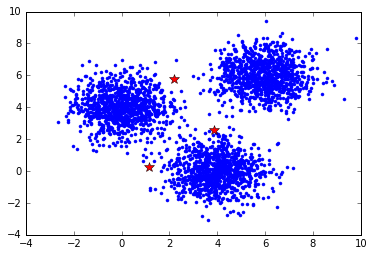

Iteration 1
[[ 2.11666908  0.48254205]
 [ 5.21498441  2.48225041]
 [ 2.44810682  5.34604124]]


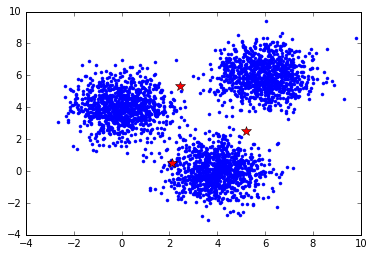

Iteration 2
[[ 2.88281232  0.25110274]
 [ 5.91323483  3.60834523]
 [ 2.06267017  5.15650083]]


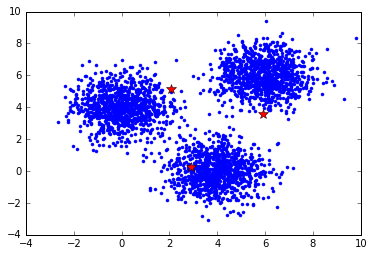

Iteration 3
[[ 3.76155925  0.02320138]
 [ 6.12357839  5.77267915]
 [ 0.51290617  4.38537614]]


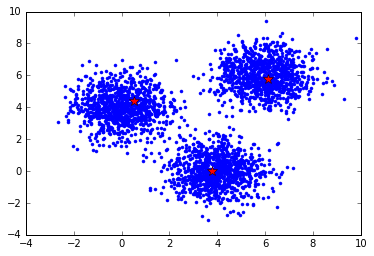

Iteration 4
[[ 3.96257607 -0.00884068]
 [ 5.94688917  5.99758619]
 [ 0.02632406  4.01797984]]


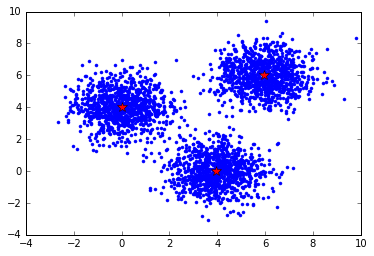

Iteration 5
[[ 3.96981346 -0.01381363]
 [ 5.9389789   5.99399726]
 [ 0.0210137   4.00852521]]


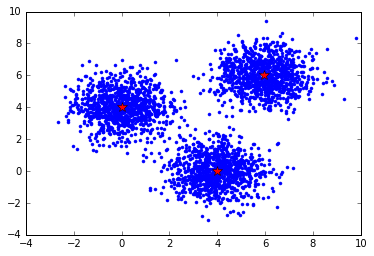

Final Results (6 iterations run)
[[ 3.96981346 -0.01381363]
 [ 5.9389789   5.99399726]
 [ 0.0210137   4.00852521]]


In [57]:
K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = sc.textFile("/home/jovyan/work/root/w261/HW11/data.csv").cache()
iter_num = 0
for i in range(10):
    ## Below I am broadcasting the current centroids to the
    ## mappers and reducers in the executors
    centroidsBroadcast = sc.broadcast(centroids)
    ## Here we are doing all the transformations in memory
    ## before the final collect action
    res = D.map(nearest_centroid_with_broadcasting)\
    .reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1]))\
    .sortByKey()\
    .map(lambda x: x[1][0]/x[1][1])
    centroids_new = np.array(res.collect())
    if np.sum(np.absolute(centroids_new-centroids))<0.01:
        break
    print "Iteration " + str(iter_num)
    iter_num = iter_num + 1 
    centroids = centroids_new
    print centroids
    plot_iteration(centroids)
print "Final Results (%d iterations run)"%iter_num
print centroids

<a name="HW11.1"> <h2 style="color:darkgreen">HW11.1 Loss Functions</h2>
[Back to Table of Contents](#TOC)

 
In the context of binary classification problems, does the linear SVM learning algorithm yield the same result as a L2-penalized logistic regression learning algorithm? 

In your reponse, please discuss the loss functions, and the learnt models, and separating surfaces between the two classes.


In the context of binary classification problems, does the linear SVM learning algorithm yield the same result as a perceptron learning algorithm? 

[OPTIONAL]: generate an artifical binary classification dataset with 2 input features and plot the learnt separating surface for both a linear SVM and for logistic regression. Comment on the learnt surfaces. Please feel free to do this in Python (no need to use Spark).

##### ANSWER:

###### LINEAR SVM VS. L2-PENALIZED LOGISTIC REGRESSION

In the context of binary classification problems, both linear SVM learning algorithms and L2-penalized logistic regression algorithms yield parameters that define a hyperplane that separates the training data. The algorithms *can* yield similar results, but I believe that SVM will yield results as performant or better than L2-regularized logistic regression.

The reason that I believe that SVM will generally outperform L2-regularized logistic regression is that linear SVM will generalize better than L2-regularized logistic regression given the same training data. The reason for this is that SVM guarantees to produce the hyperplane that *best* separates the classes in the training data where *best separation* means that it will pick the hyperplane that is farthest from the training data points. This is a constraint that does not exist in the L2-regularized logistic regression.

While they both produce a hyperplane, in terms of their loss functions, SVMs and L2-penalized logistic regressions are very different as shown below.

The loss function for SVM is a regularized hinge loss function:

$$J(w) = \sum_{i}L(m^{i}(w)) + \lambda R(w) = \sum_{i}max(0, 1 - m^{i}(w)) + \lambda R(w)$$

Where the individual loss components are as follows:
$$\lambda R(w) = \lambda||w||^2$$
$$L(m^{i}(w)) = max(0, 1 - m^{i}(w))$$
$$m^{i}(w) = y^{(i)}f_w(x^{(i)})$$
$$f_w(x^{(i)})=w^tx^{(i)}$$

The loss function for L2-penalized logistic regression is an L2-penalized log loss function:

$$J(w) = \sum_{i}L(m_i(w)) + \lambda R(w) = \sum_{i}log1 + e^{-m^i} + \lambda R(w)$$

Where the individual loss components are as follows:
$$\lambda R(w) = \lambda ||w||^2$$
$$L(m^i) = log1 + e^{-m^i}$$
$$m^i = y^{^-(i)}f_w(x^{(i)})$$
$$y^{^-(i)}=-1\text{ if } y^{(i)}=0$$
$$y^{^-(i)}=1\text{ if } y^{(i)}=1$$

Finally, another important thing to note as a difference between the algorithms is their **interpretability**. Specifically, the output weights of [L2-regularized] logistic regression has a probabilitic interpretation which is relatively easy to grasp. In comparison, linear SVM outputs weights used to compute an intermediate output, the sign of which indicates the class for the test data; that said, these weights do not have an intuitive interpretation. They *can* be interpreted as the coefficients of the resulting hyperplane, but that is not as easy to understand as the probability weight that is produced by logistic regression.

__[NEED TO CLARIFY, CAN L2 REGULARIZED LOGISTIC REGRESSION HANDLE LINEARLY NON-SEPARABLE DATA?]__

###### LINEAR SVM VS. PERCEPTRON

In the context of binary classification problems, (similar to the comaparison of linear SVM and logistic regression) linear SVM learning algorithms technically *can* yield the same result as a perceptron learning algorithm but generally they will not yield the same results; SVMs will tend to outperform perceptrons. __A perceptron *can* yield the same results as a linear SVM because technically a perceptron can be trained to yield the same separating hyperplane as a linear SVM!__ After all, their loss functions are very similar:

__Linear SVM loss function (hinge loss):__

$$L(m^{i}(w)) = max(0, 1 - m^{i}(w))$$
$$m^{i}(w) = y^{(i)}f_w(x^{(i)})$$
$$f_w(x^{(i)})=w^tx^{(i)}$$

__Perceptron loss function:__

$$L(m^{i}(w)) = max(0, - m^{i}(w))$$
$$m^{i}(w) = y^{(i)}f_w(x^{(i)})$$
$$f_w(x^{(i)})=w^tx^{(i)}$$

You can see above that hinge loss (SVM) is nothing more that the translation of the perceptron loss function one unit (note that I am exclusively examining loss functions ignoring regularization terms).

Ultimtely, both algorithms are producing hyperplanes that separate the training data in similar fashions, but SVM results, __due to the additional constraints in the SVM algorithm__, will tend to be superior as they will generalize better than the perceptron classifier produced by the same data. The reason for this is that SVM guarantees to produce the *maximal margin perceptron* which is the perceptron that produces the hyperplane with the largest margin (it is the farthest from the data it is separating); this is the additional constraint mentioned above. In fact, the critical difference between SVM and perceptron is this _constraint_ of maximizing the margin.

Finally, it is worthwhile noting that perceptrons can only handle linearly separable data whereas linear [soft] SVMs can handle both linearly separable and linearly non-separable data.

__[NEED TO CLARIFY, BUT I BELIEVE THAT PERCEPTRONS HAVE NO FORM OF REGULARIZATION WHEREAS SVMs ALWAYS HAVE L2-REGULARIZATION]__

<a name="HW11.2"><h2 style="color:darkgreen">HW11.2 Gradient descent</h2>
[Back to Table of Contents](#TOC)

In the context of logistic regression describe and define three flavors of penalized loss functions.  Are these all supported in Spark MLLib (include online references to support your answers)?

Descibe probabilistic interpretations of the L1 and L2 priors for penalized logistic regression (HINT: see synchronous slides for week 11 for details)

##### ANSWER:

###### Three flavors of penalized loss functions

In the context of logistic regression, three flavors of penalized loss functions are **no penalization**, **L1 penalization** and **L2 penalization**.

**No penalization** is the flavor of penalization where the selection of weights in the logistic regression model is not penalized by the model's complexity. That is, the model will use as many coefficients with as large a magnitude as possible to yield the best performing model given the training data. Practically, this means that among the three options considered, this is the one that has the highest risk of overfitting to the data (it yields a comparatively high-variance model).

**L2 penalization** (which leads to a "ridge logistic regression") is a penalization where the selection of weights in the logistic regression model is penalized by the model's complexity. L2 penalization is defined as:

$$R_2(w) = ||w||^2_2 = \sum_{i=1}^{p}(w_i)^2$$

Practically, L2 penalization shrinks regression coefficients towards zero, which reduces the risk of overfitting to the training data. That said, L2 penalization does not shrink coefficients to zero (i.e. it does not do feature selection).

**L1 penalization** (which leads to a "lasso logistic regression") is a penalization where the selection of weights in the logistic regression model is penalized by the model's complexity. L1 penalization is defined as:

$$R_1(w) = ||w||_1 = \sum_{i=1}^{p}|w_i|$$

Practically, L1 penalization shrinks regression coefficients towards zero even more aggressively than L2 penalization,  reducing the risk of overfitting to the training data. A key difference and benefit to L1 regularization is that it can shrink coefficients to zero, effectively doing feature selection (but the coefficients that are non-zero tend to be shrunk less than in L2 penalization).

No penalization, L1 penalization and L2 penalization are all supported for logistic regression in Spark MLLib, see the [train function under the pyspark.mllib.classification.LogisticRegressionWithLBFGS class](https://spark.apache.org/docs/1.6.0/api/python/pyspark.mllib.html#pyspark.mllib.classification.LogisticRegressionWithLBFGS) (under *Parameters:regType:None*, *Parameters:regType:l1* and *Parameters:regType:l2* respectively) for details.

###### Probabilistic interpretations of L1 and L2 priors for penalized logistic regression

It is important to note that from a probabilistic/Bayesian standpoint, **no penalization** translates to a uniform prior for the distribution of the logistic regression model's weights. This is equivalent to the belief that all the regression coefficient combinations are equally likely to be relevant for the classifier being trained.

The probabilistic interpretation of **L2 priors** is that the prior for the distribution of the logistic regression's weights follows a normal distribution centered around zero. This means that the prior shrinks all of the weights for the classifier being trained towards zero, but the weights all conserve non-zero values upon training.

The probabilistic interpretation of **L1 priors** is that the prior for the distribution of the logistic regression's weights follows a Laplace distribution centered around zero. This means that, compared to the L2 prior, the L1 prior assigns a higher density to the neighborhood of zero for the final weights. This is a direct consequence of the shape of the distributions:

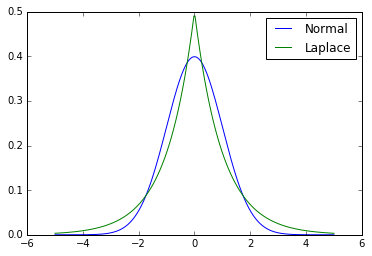

In [65]:
%matplotlib inline

from scipy.stats import laplace
from scipy.stats import norm

xs = np.linspace(-5, 5, 250)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xs, norm.pdf(xs), label='Normal');
ax.plot(xs, laplace.pdf(xs), label='Laplace');
ax.legend();

<a name="HW11.3"> <h2 style="color:darkblue"> HW11.3 Logistic Regression</h2>
[Back to Table of Contents](#TOC)

Generate 2 sets of linearly separable data with 100 data points each using the data generation code provided below and plot each in separate plots. Call one the training set and the other the testing set.

```python
def generateData(n):
 """ 
  generates a 2D linearly separable dataset with n samples. 
  The third element of the sample is the label
 """
 xb = (rand(n)*2-1)/2-0.5
 yb = (rand(n)*2-1)/2+0.5
 xr = (rand(n)*2-1)/2+0.5
 yr = (rand(n)*2-1)/2-0.5
 inputs = []
 for i in range(len(xb)):
  inputs.append([xb[i],yb[i],1])
  inputs.append([xr[i],yr[i],-1])
 return inputs

```
Modify this data generation code to generating non-linearly separable training and testing datasets (with approximately 10% of the data falling on the wrong side of the separating hyperplane. Plot the resulting datasets. 

NOTE: For the remainder of this problem please use the non-linearly separable training and testing datasets.

Using MLLib  train up a LASSO logistic regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the logistic regression model? Justify with plots and words. 

Derive and implement in Spark a weighted  LASSO logistic regression. Implement a convergence test of your choice to check for termination within your training algorithm . 

Weight the above training dataset as follows:  Weight each example using the inverse vector length (Euclidean norm): 

>weight(X)= 1/||X||, 

>where ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2)

>Here X is vector made up of X1 and X2.

Evaluate your homegrown weighted  LASSO logistic regression on the test dataset. Report misclassification error (1 - Accuracy) and how many iterations it took to converge.

Does Spark MLLib have a weighted LASSO logistic regression implementation. If so use it and report your findings on the weighted training set and test set. 

##### ANSWER:

Below I have highlighted the plots for the separable and un-separable data sets generated for this exercise. Using __MLLib to train a LASSO logistic regression model__ with the un-separable training dataset and testing on the un-separable test dataset, I found that __using a single iteration of the algorithm we arrived to the best level of performance (see accuracy as a function of iterations below) with a test misclassification rate of 8.5%.__ See below for a graph of iterations against performance.

Our __homegrown weighted LASSO logistic regression__ in Spark tests for convergence based on a very small difference in the absolute sum of the weights for the model:

    ## stopCriteria is set to 0.0001
    if sum(abs(wdelta))<=stopCriteria*sum(abs(w)): # converged as updates to weight vector are small
            break

With this algorithm I found a misclassification error rate of 8%. I also found that the algorithm converges after 900 - 1000 iterations.

**As far as I can tell, Spark MLLib does not have a weighted LASSO logistic regression implementation.** That said, given that all we are doing is normalizing the input data, we can obtain the results for a weighted LASSO logistic regression in Spark MLLib by simply preprocessing the data as we did in the homegrown situation. With this final algorithm I found a misclassification error rate of 8% as well that the algorithm plateau'd at after a single iteration.

###### Helper functions

In [82]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
import numpy as np
from math import *
import random


## Function that generates the data being used in the rest of the HW
def generateData(n,linearlySeparable=True):
    """ 
    generates a 2D linearly separable dataset with n samples. 
    The third element of the sample is the label
    """
    xb = (np.random.rand(n)*2-1)/2-0.5
    yb = (np.random.rand(n)*2-1)/2+0.5
    xr = (np.random.rand(n)*2-1)/2+0.5
    yr = (np.random.rand(n)*2-1)/2-0.5
    inputs = []
    for i in range(len(xb)):
        inputs.append([xb[i],yb[i],1])
        inputs.append([xr[i],yr[i],-1])
    if not linearlySeparable:
        inputs = np.array(inputs)
        for i in range(len(inputs)):
            if random.random() <= 0.10:
                inputs[i,2] = -inputs[i,2]
    return inputs

## Returns the objects used as input data to MLLib training algorithms
def parsedPointV2(observation):
    return LabeledPoint(observation[2], (observation[0], observation[1]))

## Unit-normalizes the data for training/testing on
def normalize_data_SPARK(data):
    data_RDD = sc.parallelize(data[:,None]) # data is the X matrix of training or test data: inseparable_test_data[:,:-1]
    normalized_dataRDD = data_RDD.map(lambda x: x/np.sqrt(np.sum(np.square(x)))).collect()
    result = np.array([[array[0][0], array[0][1]] for array in normalized_dataRDD])
    return result

#gradient descent (and with NO stochasticity!)
# Objective Function
# minw   λ/2   w’w   +   1/m Σi log(1+exp(yi(w’xi – b)))   
# gradient 
#   -y*(1-1/(1+exp(yi(w’xi – b))))*x
def weighted_logisticReg_GD_Spark(data,y,w=None,eta=0.05,iter_num=1000,regPara=0.01,stopCriteria=0.0001,reg="Ridge"):
    #eta - learning rate
    #regPara - sensitivity to regularization term
    current_iteration = 0
    dataRDD = sc.parallelize(np.append(y[:,None],data,axis=1))
    if w is None:
        w = np.random.normal(size=data.shape[1]+1)
    for i in range(iter_num):
        current_iteration = i
        ## Note we are broadcasting the weights on every iteration
        w_broadcast = sc.broadcast(w)
        g = dataRDD\
        .map(lambda x: -x[0]*(1-1/(1+np.exp(-x[0]*np.dot(w_broadcast.value,np.append(x[1:],1))))) \
                        *np.append(x[1:],1))\
        .reduce(lambda x,y:x+y)/data.shape[0] # Gradient of logloss

        if reg == "Ridge":
            wreg = w*1
            wreg[-1] = 0 #last value of weight vector is bias term; ignore in regularization
        elif reg == "Lasso":
            wreg = w*1
            wreg[-1] = 0 #last value of weight vector is bias term; ignore in regularization
            wreg = (wreg>0).astype(int)*2-1
        else:
            wreg = np.zeros(w.shape[0])
        wdelta = eta*(g+regPara*wreg)  #gradient: hinge loss + regularized term 
        if sum(abs(wdelta))<=stopCriteria*sum(abs(w)): # converged as updates to weight vector are small
            break
        w = w - wdelta
    return (w, current_iteration)

## Calculates error for homegrown model
def errorCalcV2(data, y,weights):
    dataRDD = sc.parallelize(np.append(y[:,None],data,axis=1))
    dataRDD.cache()
    testlabelsAndPreds = dataRDD\
    .map(lambda p: (p[0], e**np.dot(weights, np.append(p[1:],1))/(1+ e**np.dot(weights, np.append(p[1:],1)))))\
    .map(lambda p: (p[0], 1.0 if p[1] >= .5 else -1.0))
    testErr = testlabelsAndPreds.filter(lambda (v, p): v != p).count() / float(dataRDD.count())
    dataRDD.unpersist()
    return testErr

###### Data generation - Linearly Separable and Non-Linearly Separable

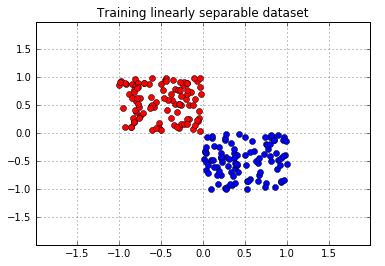

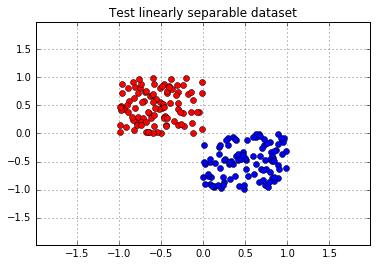

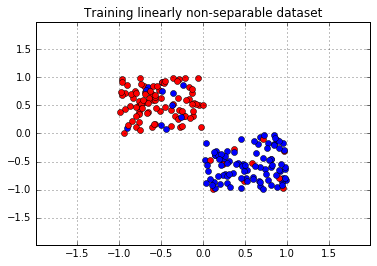

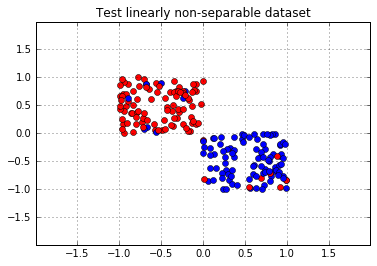

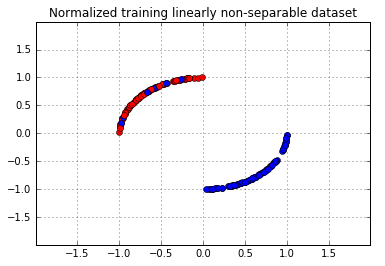

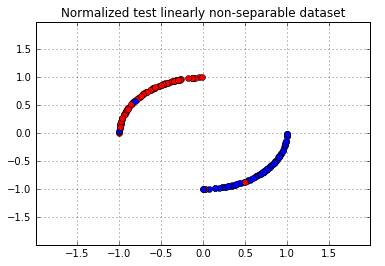

In [98]:
#########################################
## Generating and graphing separable data
#########################################

separable_train_data = np.array(generateData(100))
separable_test_data = np.array(generateData(100))

cols = {1: 'r', -1: 'b'}
for i in range(len(separable_train_data)):
    plt.plot(separable_train_data[i,0],
             separable_train_data[i,1],
             cols[separable_train_data[i,2]]+"o")

plt.title("Training linearly separable dataset")
axes = plt.gca()
axes.set_xlim([np.min(separable_train_data[:,0]) - 1,np.max(separable_train_data[:,0]) + 1])
axes.set_ylim([np.min(separable_train_data[:,1]) - 1,np.max(separable_train_data[:,1]) + 1])
plt.grid()
plt.show()

for i in range(len(separable_test_data)):
    plt.plot(separable_test_data[i,0],
             separable_test_data[i,1],
             cols[separable_test_data[i,2]]+"o")

plt.title("Test linearly separable dataset")
axes = plt.gca()
axes.set_xlim([np.min(separable_test_data[:,0]) - 1,np.max(separable_test_data[:,0]) + 1])
axes.set_ylim([np.min(separable_test_data[:,1]) - 1,np.max(separable_test_data[:,1]) + 1])
plt.grid()
plt.show()

#############################################
## Generating and graphing non-separable data
#############################################

inseparable_train_data = np.array(generateData(100, False))
inseparable_test_data = np.array(generateData(100, False))

for i in range(len(inseparable_train_data)):
    plt.plot(inseparable_train_data[i,0],
             inseparable_train_data[i,1],
             cols[inseparable_train_data[i,2]]+"o")

plt.title("Training linearly non-separable dataset")
axes = plt.gca()
axes.set_xlim([np.min(inseparable_train_data[:,0]) - 1,np.max(inseparable_train_data[:,0]) + 1])
axes.set_ylim([np.min(inseparable_train_data[:,1]) - 1,np.max(inseparable_train_data[:,1]) + 1])
plt.grid()
plt.show()

for i in range(len(inseparable_test_data)):
    plt.plot(inseparable_test_data[i,0],
             inseparable_test_data[i,1],
             cols[inseparable_test_data[i,2]]+"o")

plt.title("Test linearly non-separable dataset")
axes = plt.gca()
axes.set_xlim([np.min(inseparable_test_data[:,0]) - 1,np.max(inseparable_test_data[:,0]) + 1])
axes.set_ylim([np.min(inseparable_test_data[:,1]) - 1,np.max(inseparable_test_data[:,1]) + 1])
plt.grid()
plt.show()

########################################################
## Generating and graphing normalized non-separable data
########################################################

normalized_inseparable_train_data = normalize_data_SPARK(inseparable_train_data[:,:-1])
normalized_inseparable_test_data = normalize_data_SPARK(inseparable_test_data[:,:-1])

for i in range(len(normalized_inseparable_train_data)):
    plt.plot(normalized_inseparable_train_data[i,0],
             normalized_inseparable_train_data[i,1],
             cols[inseparable_train_data[i,2]]+"o")

plt.title("Normalized training linearly non-separable dataset")
axes = plt.gca()
axes.set_xlim([np.min(normalized_inseparable_train_data[:,0]) - 1,np.max(normalized_inseparable_train_data[:,0]) + 1])
axes.set_ylim([np.min(normalized_inseparable_train_data[:,1]) - 1,np.max(normalized_inseparable_train_data[:,1]) + 1])
plt.grid()
plt.show()

for i in range(len(inseparable_test_data)):
    plt.plot(normalized_inseparable_test_data[i,0],
             normalized_inseparable_test_data[i,1],
             cols[inseparable_test_data[i,2]]+"o")

plt.title("Normalized test linearly non-separable dataset")
axes = plt.gca()
axes.set_xlim([np.min(normalized_inseparable_test_data[:,0]) - 1,np.max(normalized_inseparable_test_data[:,0]) + 1])
axes.set_ylim([np.min(normalized_inseparable_test_data[:,1]) - 1,np.max(normalized_inseparable_test_data[:,1]) + 1])
plt.grid()
plt.show()

########################################################
## Generating and graphing normalized separable data
########################################################

normalized_separable_train_data = normalize_data_SPARK(separable_train_data[:,:-1])
normalized_separable_test_data = normalize_data_SPARK(separable_test_data[:,:-1])

###### MLLib - LASSO logistic regression

[-1.17906135174,1.24634976035]
Test Error (1 iterations) = 0.085
[-2.04165149762,1.68136485248]
Test Error (10 iterations) = 0.085
[-2.04165149762,1.68136485248]
Test Error (20 iterations) = 0.085
[-2.04165149762,1.68136485248]
Test Error (30 iterations) = 0.085
[-2.04165149762,1.68136485248]
Test Error (40 iterations) = 0.085
[-2.04165149762,1.68136485248]
Test Error (50 iterations) = 0.085
[-2.04165149762,1.68136485248]
Test Error (100 iterations) = 0.085
[-2.04165149762,1.68136485248]
Test Error (200 iterations) = 0.085
[0.085, 0.085, 0.085, 0.085, 0.085, 0.085, 0.085, 0.085]


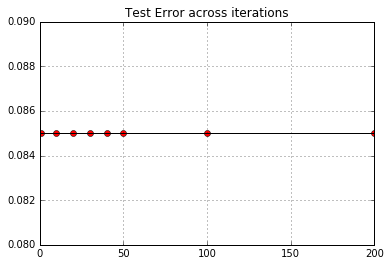

In [286]:
parsedData.unpersist()

## First, we parellelize the training dataset
train_data = sc.parallelize(inseparable_train_data)
test_data = sc.parallelize(inseparable_test_data)

## Preprocessing data for the purposes of feeding to the MLLib function
parsedTrainData = train_data.map(lambda x: [x[0],x[1],x[2] + 1.0] if x[2] == -1.0 else [x[0],x[1],x[2]])
parsedTrainData = parsedTrainData.map(parsedPointV2)

parsedTestData = test_data.map(lambda x: [x[0],x[1],x[2] + 1.0] if x[2] == -1.0 else [x[0],x[1],x[2]])
parsedTestData = parsedTestData.map(parsedPointV2)

## Fitting model with preprocessed training data (non-separable)
model = LogisticRegressionWithLBFGS.train(parsedTrainData,
                                          regType='l1')

## Predicting on the preprocessed test data given the above fitted model
testlabelsAndPreds = parsedTestData.map(lambda p: (p.label, model.predict(p.features)))

testErr = testlabelsAndPreds.filter(lambda (v, p): v != p).count() / float(parsedTestData.count())


## Now we run the model several times with different iterations to determine the
## optimal set of iterations to use

iterations = [1,10,20,30,40,50,100,200]
test_errors = []

for i in iterations:
    model = LogisticRegressionWithLBFGS.train(parsedTrainData,
                                          regType='l1',
                                             iterations=i)
    print model.weights
    testlabelsAndPreds = parsedTestData.map(lambda p: (p.label, model.predict(p.features)))
    testErr = testlabelsAndPreds.filter(lambda (v, p): v != p).count() / float(parsedTestData.count())
    print "Test Error (%d iterations) = %s"% (i,str(testErr))
    test_errors.append(testErr)
print test_errors
plt.plot(iterations,
         test_errors,
        'ro',
        iterations,
         test_errors,
        'k')
plt.title("Test Error across iterations")
plt.grid()
plt.show()

###### Homegrown weighted LASSO logistic regression

In [87]:
## Single iteration of homegrown model

output_pair = weighted_logisticReg_GD_Spark(normalized_inseparable_train_data,
                                            inseparable_train_data[:,-1],
                                           reg="Lasso")
weights, iterations_to_converge = output_pair

testErr = errorCalcV2(normalized_inseparable_test_data,
            inseparable_test_data[:,-1],
           weights)

print "These are the weights computed"
print weights
print "Iterations to converge: %d"%iterations_to_converge
print "Test Error = %s"% (str(testErr))

These are the weights computed
[-1.91398438  1.44725978 -0.32712899]
Iterations to converge: 999
Test Error = 0.08


Weights after (0 iterations):
[-0.17136725  1.05796434  0.64296906]
Test Error (0 iterations) = 0.18
Weights after (9 iterations):
[ 0.2963218   0.04366563  1.20570341]
Test Error (9 iterations) = 0.53
Weights after (99 iterations):
[-0.81088243  0.66078229  0.02395362]
Test Error (99 iterations) = 0.08
Weights after (805 iterations):
[-1.37885025  2.02817838 -0.36974097]
Test Error (805 iterations) = 0.08
Weights after (1499 iterations):
[-1.87373608  1.54638182 -0.35549578]
Test Error (1499 iterations) = 0.08


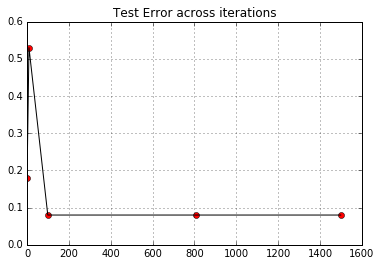

In [96]:
## Now we run the model several times with different iterations to determine the
## optimal set of iterations to use

set_iterations = [1,10,100,1000,1500]
actual_iterations = []
test_errors = []

for i in set_iterations:
    output_pair = weighted_logisticReg_GD_Spark(normalized_inseparable_train_data,
                                                inseparable_train_data[:,-1],
                                                reg="Lasso",
                                               iter_num=i)

    weights, iterations_to_converge = output_pair
    testErr = errorCalcV2(normalized_inseparable_test_data,
                          inseparable_test_data[:,-1],
                          weights)
    print "Weights after (%d iterations):"%(iterations_to_converge)
    print weights
    print "Test Error (%d iterations) = %s"% (iterations_to_converge,str(testErr))
    test_errors.append(testErr)
    actual_iterations.append(iterations_to_converge)

plt.plot(actual_iterations,
         test_errors,
        'ro',
        actual_iterations,
         test_errors,
        'k')
plt.title("Test Error across iterations")
plt.grid()
plt.show()

###### MLLib "weighted" LASSO logistic regression

Weights after (1 iterations):
[-0.963759250558,1.03634274313]
Test Error (1 iterations) = 0.08
Weights after (10 iterations):
[-1.57436134503,1.88348177131]
Test Error (10 iterations) = 0.08
Weights after (20 iterations):
[-1.57436134503,1.88348177131]
Test Error (20 iterations) = 0.08
Weights after (30 iterations):
[-1.57436134503,1.88348177131]
Test Error (30 iterations) = 0.08
Weights after (40 iterations):
[-1.57436134503,1.88348177131]
Test Error (40 iterations) = 0.08
Weights after (50 iterations):
[-1.57436134503,1.88348177131]
Test Error (50 iterations) = 0.08
Weights after (100 iterations):
[-1.57436134503,1.88348177131]
Test Error (100 iterations) = 0.08
Weights after (200 iterations):
[-1.57436134503,1.88348177131]
Test Error (200 iterations) = 0.08


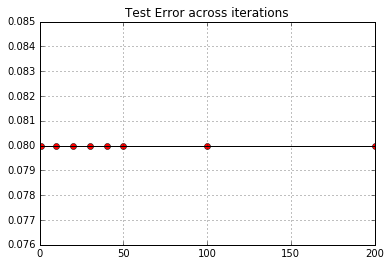

In [95]:
# parsedData.unpersist()

## First, we parellelize the training dataset
train_data = sc.parallelize(np.append(normalized_inseparable_train_data, inseparable_train_data[:,-1][:,None], axis=1))
test_data = sc.parallelize(np.append(normalized_inseparable_test_data, inseparable_test_data[:,-1][:,None], axis=1))

## Preprocessing data for the purposes of feeding to the MLLib function
parsedTrainData = train_data.map(lambda x: [x[0],x[1],x[2] + 1.0] if x[2] == -1.0 else [x[0],x[1],x[2]])
parsedTrainData = parsedTrainData.map(parsedPointV2)

parsedTestData = test_data.map(lambda x: [x[0],x[1],x[2] + 1.0] if x[2] == -1.0 else [x[0],x[1],x[2]])
parsedTestData = parsedTestData.map(parsedPointV2)

## Fitting model with preprocessed training data (non-separable)
model = LogisticRegressionWithLBFGS.train(parsedTrainData,
                                          regType='l1')

## Predicting on the preprocessed test data given the above fitted model
testlabelsAndPreds = parsedTestData.map(lambda p: (p.label, model.predict(p.features)))

testErr = testlabelsAndPreds.filter(lambda (v, p): v != p).count() / float(parsedTestData.count())


## Now we run the model several times with different iterations to determine the
## optimal set of iterations to use

iterations = [1,10,20,30,40,50,100,200]
test_errors = []

for i in iterations:
    model = LogisticRegressionWithLBFGS.train(parsedTrainData,
                                          regType='l1',
                                             iterations=i)
    print "Weights after (%d iterations):"%(i)
    print model.weights
    testlabelsAndPreds = parsedTestData.map(lambda p: (p.label, model.predict(p.features)))
    testErr = testlabelsAndPreds.filter(lambda (v, p): v != p).count() / float(parsedTestData.count())
    print "Test Error (%d iterations) = %s"% (i,str(testErr))
    test_errors.append(testErr)

plt.plot(iterations,
         test_errors,
        'ro',
        iterations,
         test_errors,
        'k')
plt.title("Test Error across iterations")
plt.grid()
plt.show()

<a name="HW11.4"><h2 style="color:darkblue"> HW11.4 SVMs  </h2>
[Back to Table of Contents](#TOC)

Use the non-linearly separable training and testing datasets from HW11.3 in this problem.

Using MLLib  train up a soft SVM model with the training dataset and evaluate with the testing set. What is a good number of iterations for training the SVM model? Justify with plots and words. 

__HW11.4.1 [Optional]__
Derive and Implement in Spark a weighted hard linear svm classification learning algorithm. Feel free to use the following notebook as a starting point  
> [SVM Notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/dm2l73iznde7y4f/SVM-Notebook-Linear-Kernel-2015-06-19.ipynb).

Evaluate your homegrown weighted  linear svm classification learning algorithm on the  weighted training dataset and test dataset from HW11.3 (linearly separable dataset). Report misclassification error (1 - Accuracy) and how many iterations does it took to converge?  How many support vectors do you end up with?

Does Spark MLLib have a weighted soft SVM learner. If so use it and report your findings on the weighted training set and test set.  

__HW11.4.2 [Optional]__
Repeat HW11.4.2 using a soft SVM and a nonlinearly separable datasets. Compare the error rates that you get here with the error rates you achieve using MLLib's soft SVM. Report the number of support vectors in both cases (may not be available the MLLib implementation).

##### ANSWER:

Using __MLLib to train a soft SVM model__ with the non-separable training dataset and testing on the non-separable test dataset, I found that __using a single iteration of the algorithm we arrived to the best level of performance (see accuracy as a function of iterations below) with a test misclassification rate of 8.5%.__ See below for a graph of iterations against performance.

__Answer HW11.4.1 [Optional]__

Our __homegrown weighted hard SVM classifier__ trained and tested on separable data, found a misclassification error rate of 0%! I also found that the algorithm reaches this performance somewhere between 400 - 1000 iterations.

###### Helper functions

In [113]:
from pyspark.mllib.classification import SVMWithSGD

## normalizes input and test data
def normalize_data_SPARK(data):
    data_RDD = sc.parallelize(data[:,None]) # data is the X matrix of training or test data: inseparable_test_data[:,:-1]
    normalized_dataRDD = data_RDD.map(lambda x: x/np.sqrt(np.sum(np.square(x)))).collect()
    result = np.array([[array[0][0], array[0][1]] for array in normalized_dataRDD])
    return result


#gradient descent (and with NO stochasticity!)
# Objective Function
# minw   λ/2   w’w   +   1/m Σi(1   –    yi(w’xi – b))+
# gradient 
#   λw               if      yi(w’xi – b))  > 1    #correctly classified
#   λw  + yi xi      Otherwise                    #incorrectly classified
#--------------------------------
#Wt+1  = wt + average(gradient)
#Wt+1  = wt + average(regularization + hinge loss)

def weighted_SVM_GD_SPARK(data,y,w=None,eta=0.01,iter_num=1000,regPara=0.01,stopCriteria=0.0001):
    #eta learning rate
    #regPara
    current_iterations = 0
    dataRDD = sc.parallelize(np.append(y[:,None],data,axis=1)) #prepend y to X
    dataRDD.cache()
#     normalized_dataRDD = dataRDD.map(lambda x: x/np.sqrt(np.sum(np.square(np.append(x[1:],1))))).cache()
    if w==None:
        w = np.random.normal(size=data.shape[1]+1)
    for i in range(iter_num):       #label * margin
        current_iterations = i
        sv = dataRDD.filter(lambda x:x[0]*np.dot(w,np.append(x[1:],1)) <= 1)  #Support vector? with label*margin<1
        if sv.isEmpty(): # converged as no more updates possible
            break       # hinge loss component of gradient y*x and sum up 
        g = -sv.map(lambda x:x[0]*np.append(x[1:],1)).reduce(lambda x,y:x+y)/data.shape[0] #gradient: avg hinge loss
        wreg = w*1   #temp copy of weight vector
        wreg[-1] = 0 #last value of weight vector is bias term; ignore in regularization
        wdelta = eta*(g+regPara*wreg)  #gradient: hinge loss + regularized term 
        if sum(abs(wdelta))<=stopCriteria*sum(abs(w)): # converged as updates to weight vector are small
            break
        w = w - wdelta
        support_vectors = dataRDD.filter(lambda x:x[0]*np.dot(w,np.append(x[1:],1)) == 1).count()
    dataRDD.unpersist()
    return (w, current_iterations, support_vectors)

## Calculate error for fitted SVM
def SVM_errorCalcV2(data, y, weights):
    dataRDD = sc.parallelize(np.append(y[:,None],data,axis=1))
    dataRDD.cache()
    testlabelsAndPreds = dataRDD\
    .map(lambda p: (p[0], np.dot(weights, np.append(p[1:],1))))\
    .map(lambda p: (p[0], 1.0 if p[1] >= 0 else -1.0))
    testErr = testlabelsAndPreds.filter(lambda (v, p): v != p).count() / float(dataRDD.count())
    dataRDD.unpersist()
    return testErr

###### MLLib - Soft SVM

Test Error = 0.085
Test Error (1 iterations) = 0.085
Test Error (10 iterations) = 0.085
Test Error (20 iterations) = 0.085
Test Error (30 iterations) = 0.085
Test Error (40 iterations) = 0.085
Test Error (50 iterations) = 0.085
Test Error (100 iterations) = 0.085
Test Error (200 iterations) = 0.085
[0.085, 0.085, 0.085, 0.085, 0.085, 0.085, 0.085, 0.085]


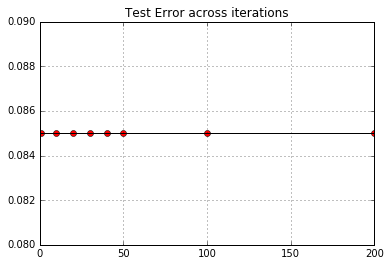

In [274]:
## First run model a single iteration

SVM_model = SVMWithSGD.train(parsedTrainData,
                             regType='l1')

SVM_testlabelsAndPreds = parsedTestData.map(lambda p: (p.label, SVM_model.predict(p.features)))

SVM_testErr = SVM_testlabelsAndPreds.filter(lambda (v, p): v != p).count() / float(parsedTestData.count())

print("Test Error = " + str(SVM_testErr))

## Now we run the model several times with different iterations to determine the
## optimal set of iterations to use

iterations = [1,10,20,30,40,50,100,200]
SVM_test_errors = []

for i in iterations:
    SVM_model = SVMWithSGD.train(parsedTrainData,
                             regType='l1',
                             iterations=i)
    SVM_testlabelsAndPreds = parsedTestData.map(lambda p: (p.label, SVM_model.predict(p.features)))
    SVM_testErr = SVM_testlabelsAndPreds.filter(lambda (v, p): v != p).count() / float(parsedTestData.count())
    print "Test Error (%d iterations) = %s"% (i,str(SVM_testErr))
    SVM_test_errors.append(SVM_testErr)
print SVM_test_errors
plt.plot(iterations,
         SVM_test_errors,
        'ro',
        iterations,
         SVM_test_errors,
        'k')
plt.title("Test Error across iterations")
plt.grid()
plt.show()

##### Homegrown Spark Hard SVM

In [114]:
## First run model a single iteration
output_pair = weighted_SVM_GD_SPARK(normalized_separable_train_data,
                                            separable_train_data[:,-1])
weights, iterations_to_converge, num_support_vectors = output_pair

testErr = SVM_errorCalcV2(normalized_separable_test_data,
            separable_test_data[:,-1],
           weights)

print "These are the weights computed"
print weights
print "Iterations to converge: %d"%iterations_to_converge
print "Test Error = %s"% (str(testErr))
print "Using %d support vectors"%num_support_vectors

These are the weights computed
[-0.9325454   0.95951324 -0.01525637]
Iterations to converge: 749
Test Error = 0.0
Using 0 support vectors


Weights after (0 iterations):
[-0.50522803 -0.34991714 -0.94936146]
Test Error (0 iterations) = 0.5
Weights after (9 iterations):
[ 0.10230288 -0.98669421  0.71339092]
Test Error (9 iterations) = 0.75
Weights after (99 iterations):
[ 1.55389726  2.03001566 -0.52933325]
Test Error (99 iterations) = 0.465
Weights after (497 iterations):
[-1.71078918  1.5974249  -0.76890609]
Test Error (497 iterations) = 0.0
Weights after (1054 iterations):
[-1.15947446  0.94857854  0.00609882]
Test Error (1054 iterations) = 0.0


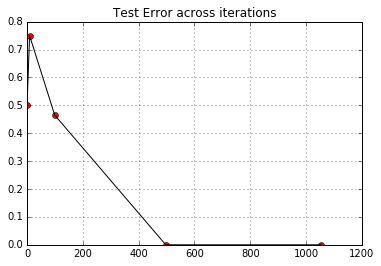

In [110]:
## Now we run the model several times with different iterations to determine the
## optimal set of iterations to use

set_iterations = [1,10,100,1000,1500]
actual_iterations = []
test_errors = []

for i in set_iterations:
    output_pair = weighted_SVM_GD_SPARK(normalized_separable_train_data,
                                                separable_train_data[:,-1],
                                               iter_num=i)

    weights, iterations_to_converge = output_pair
    testErr = SVM_errorCalcV2(normalized_separable_test_data,
                          separable_test_data[:,-1],
                          weights)
    print "Weights after (%d iterations):"%(iterations_to_converge)
    print weights
    print "Test Error (%d iterations) = %s"% (iterations_to_converge,str(testErr))
    test_errors.append(testErr)
    actual_iterations.append(iterations_to_converge)
# print test_errors
plt.plot(actual_iterations,
         test_errors,
        'ro',
        actual_iterations,
         test_errors,
        'k')
plt.title("Test Error across iterations")
plt.grid()
plt.show()

<a name="HW11.5"><h2 style="color:darkgreen"> HW11.5  [OPTIONAL] Distributed Perceptron algorithm. </h2>
[Back to Table of Contents](#TOC)

Using the following papers as background:
http://static.googleusercontent.com/external_content/untrusted_dlcp/research.google.com/en//pubs/archive/36266.pdf

https://www.dropbox.com/s/a5pdcp0r8ptudgj/gesmundo-tomeh-eacl-2012.pdf?dl=0

http://www.slideshare.net/matsubaray/distributed-perceptron 

Implement each of the following flavors of perceptron learning algorithm:

1. Serial (All Data): This is the classifier returned if trained serially on all the available data.  On a single computer for example (Mistake driven)
2. Serial (Sub Sampling): Shard the data, select one shard randomly and train serially. 
3. Parallel (Parameter Mix): Learn a perceptron locally on each shard: 
Once learning is complete combine each learnt percepton using a uniform weighting
4. Parallel (Iterative Parameter Mix) as described in the above papers.

In [72]:
## Drivers & Runners

In [73]:
## Run Scripts, S3 Sync

<a name="HW11.6"><h2 style="color:darkblue"> HW11.6 [OPTIONAL: consider doing this in a group]  Evalution of perceptron algorihtms on PennTreeBank POS corpus </h2>
[Back to Table of Contents](#TOC)

Reproduce the experiments reported in the following paper:

*Prediction with MapReduce - Andrea Gesmundo and  Nadi Tomeh*

http://www.aclweb.org/anthology/E12-2020 

These experiments focus on the prediction accuracy on a part-of-speech
(POS) task using the PennTreeBank corpus. They use sections 0-18 of the Wall
Street Journal for training, and sections 22-24 for testing.
 


<a name="HW11.7"><h2 style="color:darkgreen"> HW11.7 [OPTIONAL: consider doing this in a group] Kernal Adatron  </h2>
[Back to Table of Contents](#TOC)

Implement the Kernal Adatron in Spark (contact Jimi for details)


<a name="HW11.8"><h2 style="color:darkgreen"> HW11.8 [OPTIONAL] Create an animation of gradient descent for the Perceptron learning or for the logistic regression </h2>
[Back to Table of Contents](#TOC)
    
Learning with the following 3 training examples. Present the progress in terms of the 2 dimensional input space in terms of a contour plot and also in terms of the 3D surface plot. See Live slides for an example.
[Back to Table of Contents](#TOC)
Here is a sample training dataset that can be used:
-2, 3, +1
-1, -1, -1
2, -3, 1

Please feel free to use 
 + R (yes R!)
 + d3
 + https://plot.ly/python/
 + Matplotlib

I am happy for folks to collaborate on HW11.8 also.

It would be great to get the 3D surface and contours lines (with solution region and label normalized data) all in the same graph




In [77]:
## Code goes here

In [78]:
## Drivers & Runners

In [79]:
## Run Scripts, S3 Sync

[Back to Table of Contents](#TOC)
<center><div class='jumbotron'><h2 style='color:green'>-------  END OF HOWEWORK --------</h2></div></center>